

# Example 4.5: Classification of MNIST data


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# read the data from torchvision.datasets
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# load the data using dataloaders
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.softmax_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.softmax_relu_stack(x)
        return logits

model = NeuralNetwork()

## Hyperparameters

Hyperparameters are adjustable parameters that let you control the model optimization process.
Different hyperparameter values can impact model training and convergence rates
([read more](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)_ about hyperparameter tuning)

We define the following hyperparameters for training:
 - **Number of Epochs** - the number times to iterate over the dataset
 - **Batch Size** - the number of data samples propagated through the network before the parameters are updated
 - **Learning Rate** - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.




In [4]:
learning_rate = 1e-2
batch_size = 64
epochs = 50

## Optimization Loop

Once we set our hyperparameters, we can then train and optimize our model with an optimization loop. Each
iteration of the optimization loop is called an **epoch**.

Each epoch consists of two main parts:
 - **The Train Loop** - iterate over the training dataset and try to converge to optimal parameters.
 - **The Validation/Test Loop** - iterate over the test dataset to check if model performance is improving.

Let's briefly familiarize ourselves with some of the concepts used in the training loop. Jump ahead to
see the `full-impl-label` of the optimization loop.

### Loss Function

When presented with some training data, our untrained network is likely not to give the correct
answer. **Loss function** measures the degree of dissimilarity of obtained result to the target value,
and it is the loss function that we want to minimize during training. To calculate the loss we make a
prediction using the inputs of our given data sample and compare it against the true data label value.

Common loss functions include [nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) for regression tasks, and
[nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (Negative Log Likelihood) for classification.
[nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combines ``nn.LogSoftmax`` and ``nn.NLLLoss``.

We pass our model's output logits to ``nn.CrossEntropyLoss``, which will normalize the logits and compute the prediction error.



In [5]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizer

Optimization is the process of adjusting model parameters to reduce model error in each training step. **Optimization algorithms** define how this process is performed (in this example we use Stochastic Gradient Descent).
All optimization logic is encapsulated in  the ``optimizer`` object. Here, we use the SGD optimizer; additionally, there are many [different optimizers](https://pytorch.org/docs/stable/optim.html)
available in PyTorch such as ADAM and RMSProp, that work better for different kinds of models and data.

We initialize the optimizer by registering the model's parameters that need to be trained, and passing in the learning rate hyperparameter.



In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Inside the training loop, optimization happens in three steps:
 * Call ``optimizer.zero_grad()`` to reset the gradients of model parameters. Gradients by default add up; to prevent double-counting, we explicitly zero them at each iteration.
 * Backpropagate the prediction loss with a call to ``loss.backward()``. PyTorch deposits the gradients of the loss w.r.t. each parameter.
 * Once we have our gradients, we call ``optimizer.step()`` to adjust the parameters by the gradients collected in the backward pass.




## Full Implementation
We define ``train_loop`` that loops over our optimization code, and ``test_loop`` that
evaluates the model's performance against our test data.



In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    train_loss /= num_batches
    correct /= size
    print(f"Train Error: \n Accuracy: {(correct*100):>0.1f}%, Avg loss: {train_loss:>8f} \n")
    
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, correct

We initialize the loss function and optimizer, and pass it to ``train_loop`` and ``test_loop``.
Feel free to increase the number of epochs to track the model's improving performance.



In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss, test_loss = [], []
train_acc, test_acc = [], []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss, acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(loss), train_acc.append(acc)
    
    loss, acc = test_loop(test_dataloader, model, loss_fn)
    test_loss.append(loss), test_acc.append(acc)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302969  [   64/60000]
loss: 2.302589  [ 6464/60000]
loss: 2.300966  [12864/60000]
loss: 2.300032  [19264/60000]
loss: 2.298948  [25664/60000]
loss: 2.294792  [32064/60000]
loss: 2.294962  [38464/60000]
loss: 2.291120  [44864/60000]
loss: 2.290740  [51264/60000]
loss: 2.287424  [57664/60000]
Train Error: 
 Accuracy: 17.5%, Avg loss: 2.295949 

Test Error: 
 Accuracy: 20.1%, Avg loss: 2.286279 

Epoch 2
-------------------------------
loss: 2.286922  [   64/60000]
loss: 2.288030  [ 6464/60000]
loss: 2.278654  [12864/60000]
loss: 2.279971  [19264/60000]
loss: 2.274525  [25664/60000]
loss: 2.254508  [32064/60000]
loss: 2.260484  [38464/60000]
loss: 2.235984  [44864/60000]
loss: 2.237033  [51264/60000]
loss: 2.199421  [57664/60000]
Train Error: 
 Accuracy: 33.3%, Avg loss: 2.257286 

Test Error: 
 Accuracy: 33.1%, Avg loss: 2.191174 

Epoch 3
-------------------------------
loss: 2.212098  [   64/60000]
loss: 2.195966  [ 6464/60000]
loss: 2.13

loss: 1.643409  [32064/60000]
loss: 1.672040  [38464/60000]
loss: 1.681298  [44864/60000]
loss: 1.679432  [51264/60000]
loss: 1.706381  [57664/60000]
Train Error: 
 Accuracy: 80.0%, Avg loss: 1.670795 

Test Error: 
 Accuracy: 79.2%, Avg loss: 1.676912 

Epoch 20
-------------------------------
loss: 1.673164  [   64/60000]
loss: 1.727022  [ 6464/60000]
loss: 1.631067  [12864/60000]
loss: 1.713603  [19264/60000]
loss: 1.682607  [25664/60000]
loss: 1.642359  [32064/60000]
loss: 1.669164  [38464/60000]
loss: 1.680026  [44864/60000]
loss: 1.676706  [51264/60000]
loss: 1.703818  [57664/60000]
Train Error: 
 Accuracy: 80.1%, Avg loss: 1.668877 

Test Error: 
 Accuracy: 79.3%, Avg loss: 1.675209 

Epoch 21
-------------------------------
loss: 1.670364  [   64/60000]
loss: 1.723390  [ 6464/60000]
loss: 1.630616  [12864/60000]
loss: 1.709965  [19264/60000]
loss: 1.678203  [25664/60000]
loss: 1.641393  [32064/60000]
loss: 1.666347  [38464/60000]
loss: 1.678928  [44864/60000]
loss: 1.674069  [5

Test Error: 
 Accuracy: 80.6%, Avg loss: 1.659698 

Epoch 38
-------------------------------
loss: 1.645706  [   64/60000]
loss: 1.688836  [ 6464/60000]
loss: 1.622117  [12864/60000]
loss: 1.674467  [19264/60000]
loss: 1.623721  [25664/60000]
loss: 1.628312  [32064/60000]
loss: 1.639625  [38464/60000]
loss: 1.673656  [44864/60000]
loss: 1.642560  [51264/60000]
loss: 1.679926  [57664/60000]
Train Error: 
 Accuracy: 81.8%, Avg loss: 1.649878 

Test Error: 
 Accuracy: 80.6%, Avg loss: 1.659181 

Epoch 39
-------------------------------
loss: 1.645207  [   64/60000]
loss: 1.687452  [ 6464/60000]
loss: 1.621748  [12864/60000]
loss: 1.673539  [19264/60000]
loss: 1.621570  [25664/60000]
loss: 1.627594  [32064/60000]
loss: 1.638688  [38464/60000]
loss: 1.673648  [44864/60000]
loss: 1.641478  [51264/60000]
loss: 1.679395  [57664/60000]
Train Error: 
 Accuracy: 81.8%, Avg loss: 1.649266 

Test Error: 
 Accuracy: 80.7%, Avg loss: 1.658689 

Epoch 40
-------------------------------
loss: 1.644750 

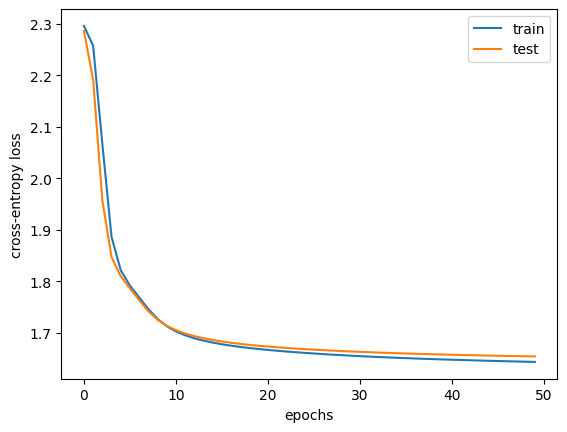

In [9]:
import matplotlib.pylab as plt

# plot learning curves
plt.figure(1)
plt.plot(range(epochs), train_loss, label='train')
plt.plot(range(epochs), test_loss, label = "test")
plt.xlabel('epochs')
plt.ylabel('cross-entropy loss')
plt.legend()

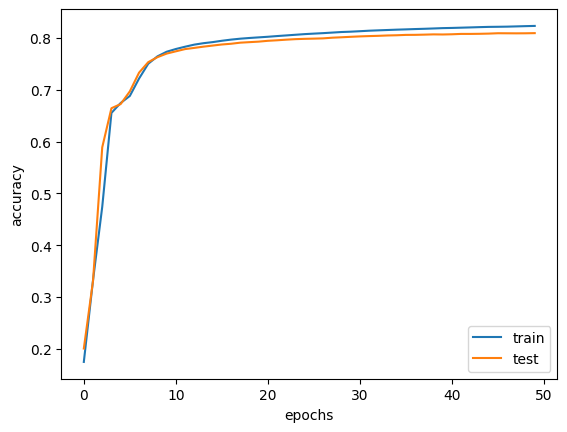

In [10]:
# plot learning curves
plt.figure(2)
plt.plot(range(epochs), train_acc, label='train')
plt.plot(range(epochs), test_acc, label = "test")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()